# Django连接MySQL

```
DATABASES = {
    'default': {
    'ENGINE': 'django.db.backends.mysql',
    'NAME':'test',
    'USER': 'root',
    'PASSWORD': '123123',
    'HOST': '192.168.182.128',
    'PORT': '3306',
    }
}
```

# 查看orm操作执行的原生SQL语句

在整个项目的settings.py里增加

```
LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'handlers': {
        'console':{
            'level':'DEBUG',
            'class':'logging.StreamHandler',
        },
    },
    'loggers': {
        'django.db.backends': {
            'handlers': ['console'],
            'propagate': True,
            'level':'DEBUG',
        },
    }
}
```

要想使用django的orm帮忙生成表，需要在setings文件注册APP
```
INSTALLED_APPS = [
    'django.contrib.admin',
    'django.contrib.auth',
    'django.contrib.contenttypes',
    'django.contrib.sessions',
    'django.contrib.messages',
    'django.contrib.staticfiles',
    'book.apps.BookConfig'
]
```
其中 book.apps.BookConfig 就是我们要注册的app.

# manage.py数据库迁移相关

* python manage.py makemigrations   # 根据app下的migrations目录中的记录，检测当前model层代码是否发生变化？
* python manage.py migrate          # 把orm代码转换成sql语句去数据库执行
* python manage.py migrate --fake     # 只记录变化，不提交数据库操作，使用较多，因为在开发中数据库一般是DBA创建的
* python manage.py dumpdata [应用名] >> data.json  # 导出数据，当前目录存在data.json的时候使用 >> 会覆盖文件，使用 > 的时候如果存在同名文件会抛出文件已存在的异常。如果不加应用名表示当前项目所有app
* python manage.py loaddata data.json    # 把dumpdata的数据导入数据库


# modles.py创建表

1. 字符串类： models.CharField  对应的是MySQL的varchar数据类型，不是char类型
2. 时间类
3. 数字字段
4. 枚举字段


## 枚举字段


在数据库存储枚举类型，比外键有什么优势是：无需连表查询性能低，省硬盘空间(选项不固定时用外键)。劣势是 在modle文件里不能动态增加。


In [ ]:
from django.db import models

class Person(models.Model):
    SHIRT_SIZES = (
    ('S', 'Small'),
    ('M', 'Medium'),
    ('L', 'Large'),
    )
    name = models.CharField(max_length=60)
    shirt_size = models.CharField(max_length=1, choices=SHIRT_SIZES)


In [3]:
p = Person(name="Fred Flintstone", shirt_size="L")
p.save()
# 'L'
p.shirt_size
# 'Large'
p.get_shirt_size_display()


## 加索引

db_index = True 表示设置索引; unique = True 设置唯一索引




```
class Meta:
    # 联合唯一索引
    unique_together = (
     ('email','ctime'),
    )
    # 联合索引（不做限制）
    index_together = (
    ('name','age'),
    )
```

# ORM表操作

## QuerySet与惰性机制

### QuerySet
all()或filter()或values() 等都只是返回了一个QuerySet（查询结果集对象）, QuerySet对象可以调用QuerySet对象的方法，所以我们经常可以看到filter().values() 这种写法。

### 惰性机制

Django的QuerySet是惰性的。下例中article_list试图从数据库查询一个标题含有django的全部文章列表。

`article_list = Article.objects.filter(title__contains="django")`
但是当我们定义article_list的时候，Django的数据接口QuerySet并没有对数据库进行任何查询。无论你加多少过滤条件，Django都不会对数据库进行查询。只有当你需要对article_list做进一步运算时（比如打印出查询结果，判断是否存在，统计查询结果长度)，Django才会真正执行对数据库的查询(见下例1)。这个过程被称为queryset的执行(evaluation)。Django这样设计的本意是尽量减少对数据库的无效操作，比如查询了结果而不用是计算资源的很大浪费。

```
for article in article_list:
    print(article.title)
```
#### Django的QuerySet自带缓存(Cache)
当遍历queryset(city_list)时，匹配的记录会从数据库获取。结果会载入内存并保存在queryset内置的cache中。如果再次遍历或读取这个article_list时，就不需要重复查询，这样也可减少对数据库的查询。
#### 用if也会导致queryset的执行
查询集为空的情况，就不进行查询操作，添加if判断,避免了对数据库的查询操作
```
city_list= City.objects.filter('name__contains'='京')
if city_list:
    for city in city_list:
        print(city)
else:
    print('No data')

```
queryset不为空，django会对执行过的queryset进行缓存(if会导致queryset执行, 缓存article_list)，所以在遍历article_list时不用担心Django会对数据库进行二次查询。
"""
有时只想要了解查询的结果是否存在，而不需使用整个数据集，这时if触发整个queryset的缓存变成了一件坏事情。此时可用exists()方法。与if判断不同，exists只会检查查询结果是否存在，返回True或False，而不会缓存article_list
```
city_list= City.objects.filter('name__contains'='京')
if city_list.exists():
    print('queryset')
else:
    print('No data')
```
**注意: 判断查询结果是否存在到底用if还是exists取决于是否希望缓存查询数据集复用，如果是用if，反之用exists**

#### 统计查询结果数量优选count方法

len()与count():均能统计查询结果的数量

* count:更快，它是从数据库层面直接获取查询结果的数量，而不是返回整个查询集
* len:会导致queryset的执行，需将整个queryset载入内存后才能统计其长度。但如果数据集queryset已经在缓存里了，使用len更快，因为它不需要跟数据库再次打交道。

```
city_list = City.objects.filter(name__contains="京")
if city_list:   # 执行了查询操作，并载入到内存
    print("{} records found.".format(city_list.len())) # 直接获取长度
```

#### 当queryset非常大时，数据按需取
queryset比较大，占用大量内存(缓存).使用values和value_list方法按需提取数据.values和values_list是以字典形式返回数据，而不是对象集合.

#### 更新数据库部分字段请用update方法
如果需要对数据库中的某条已有数据或某些字段进行更新，更好的方式是用update，而不是save方法。save会把所有的字段都重新覆盖一次，即使该字段的值没有发生改变

In [ ]:
# 对比以下两种查询
# 1 执行了查询，并将查询结果放置在queryset的缓存中，city_list可以复用
city_list= City.objects.filter('name__contains'='京')
for city in city_list:
    print(city)

# 2 不可复用
for city in City.objects.filter('name__contains'='京')：
    print(city)

In [ ]:
class Author(models.Model):
    name = models.CharField(max_length=32, null=True)
    age = models.PositiveSmallIntegerField(default=23)

    author_detail = models.OneToOneField(
        to="AuthorDetail", on_delete=models.CASCADE)

    class Meta:
        db_table = "author"


class AuthorDetail(models.Model):
    birthday = models.DateField(auto_now_add=True)
    telephone = models.CharField(max_length=11)

    class Meta:
        db_table = "author_detail"


class Publisher(models.Model):
    nid = models.AutoField(primary_key=True)
    name = models.CharField(max_length=32)
    city = models.CharField(max_length=32)

    class Meta:
        db_table = "publisher"
        index_together = ("name", "city")
        # 唯一组合索引
        # unique_together = ("name", "city")


class Book(models.Model):
    title = models.CharField(max_length=32)
    publish_date = models.DateField(auto_now_add=True)
    # 最大的8位不包括点和符号
    price = models.DecimalField(max_digits=8, decimal_places=2)
    # 这里不需要加 _id, 在数据库会自动变为 publisher_id, 如果加了db_column，那么字段名以db_column设置的为准
    publisher = models.ForeignKey(to="Publisher",
                                  db_column="pid",
                                  on_delete=models.CASCADE,
                                  to_field="nid",
                                  related_name="books")
    authors = models.ManyToManyField(to="Author")

    class Meta:
        db_table = "book"

In [ ]:
# 以外键字段进行添加
models.Book.objects.create(title='笑傲江湖',price=200,date=1968,classify_id=6, pid=6)
# 以外键对象进行添加
publisher = Publisher.objects.get(pk=1)
models.Book.objects.create(title='笑傲江湖',price=200,date=1968,classify_id=6, publisher=publisher)

In [ ]:
# 多对多表的增删改查
# 1. 查
b1.authors.all()
# 增加
b1.authors.add(1,2)
b1.authors.add(author1,author2)
# 删 在删的时候如果没有对应关系也不会报错，例如remove(1, 3) 其中1在关系表，3不在，那么最终的结果是1的关系被删除，3也不会报错
b1.authors.remove(1,2)
b1.authors.remove(author1,author2)
# 清空
b1.authors.clear()
# set = clear + add  唯一需要注意的是set接收的对象是一个可迭代对象，例如列表等

反向操作使用 表名_set 的形式，如果ForeignKey或ManyToManyField都使用了related_name参数，那么反向查询使用related_name指定的名称。

**几个操作特殊操作**
* bulk_create: 根据ps这个可迭代对象的长度和每次insert的大小，拼装多条insert的sql语句，如 Publisher.objects.bulk_create(ps, batch_size=1)
* get_or_create()：有就获取过来，没有就创建，用它可以避免重复，但是速度可以会慢些，因为要先尝试获取，看看有没有. 如Publisher.objects.get_or_create(name='人民出版部',city='北京'), 返回的结果是(<Publisher: Publisher object (1)>, False)。如果没有找到那么执行insert操作，返回的结果是 (<Publisher: Publisher object (2)>, True). 值得说明的是，get_or_create 的条件如果能get，那么只有当查询条件只返回一个对象才不会报错
* update_or_create: 查询到了就更新，查询不到就创建defaults={} 中的数据，如models.Token.objects.update_or_create(user=user, defaults={'token': tk})
* distinct: distinct一般和values结合使用，因为如果仅仅是Book.objects.all().distinct(), 那么没有什么意义，因为主键肯定是不同的。

## 了不起的双下划线

django中双下划线既可以用于单表查询，也可以用于跨表查询。比如要查id>1的记录，filter(id>1) ? 这样的id>1的写法在mysql中是可以的，但是python中的filter是函数，传参需要符合传参的规则(a=1这种形式)，所以使用filter(id__gt=1)。
```
Entry.objects.filter(pub_date__date__gt=datetime.date(2005, 1, 1))
Entry.objects.filter(pub_date__year__gte=2005)
Entry.objects.get(title__iregex=r'^(an?|the) +')
```
对于跨表查询，filter和values都可以使用这种双下划线的跨表查询。正向使用ForeignKey或ManyToManyField的字段，反向查询使用 小写表名，如果指定related_name 就使用 related_name。

## 分组和聚合


### 聚合

aggregate(*args, **kwargs)

aggregate()是QuerySet 的一个终止子句，意思是说，它返回一个包含一些键值对的字典。键的名称是聚合值的标识符，值是计算出来的聚合值。键的名称是按照字段和聚合函数的名称自动生成出来的。如果你想要为聚合值指定一个名称，可以向聚合子句提供它。




In [ ]:
# {'average_price': 23.34, 'max_price': Decimal('23.34')}
Book.objects.aggregate(average_price=Avg('price'), max_price=Max('price'))

### 分组

annotate()为调用的QuerySet中每一个对象都生成一个独立的统计值（统计方法用聚合函数）。annotate语法也支持双下划线的跨表查询，跨表分组查询本质就是将关联表join成一张表，再按单表的思路进行分组查询。另外<font color="red">annotate的返回值是querySet，</font>如果不想遍历对象，可以用上values.

* annotate的前面一般可以用values，表示根据什么进行分组
* annotate也可以直接使用对象进行分组，根据对象进行分组得到的对象列表除了原有属性还会多一些分组属性(相当于根据单个对象进行聚合)。




In [ ]:
# <QuerySet [{'publish_date': datetime.date(2019, 7, 8), 'm': Decimal('23.34')}]>
Book.objects.values('publish_date').annotate(m=Max('price'))
# 此时得到的queryset里的book对象除了包含自身属性外，还包含m属性，这种方式其实使用的还是比较多的
Book.objects.annotate(m=Max('publisher__name'))

## 几种特殊的表设计

### 1对多自关联(由原来的2张表, 变成一张表) 




In [ ]:
class Comment(models.Model):
    """
    评论表
    """
    news_id = models.IntegerField()            # 新闻ID
    content = models.CharField(max_length=32)  # 评论内容
    user = models.CharField(max_length=32)     # 评论者
    reply = models.ForeignKey('Comment',null=True,blank=True,related_name='dui') #回复ID

### 自定义第三张关系表 也使用ManyToManyField('Boy')字段(杂交类型)

只能用来查看，不能用来新增数据。

In [ ]:
class UserInfo(AbstractUser):
    """
    用户信息
    """
    nid = models.BigAutoField(primary_key=True)
    nickname = models.CharField(verbose_name='昵称', max_length=32)
    telephone = models.CharField(max_length=11, blank=True, null=True, unique=True, verbose_name='手机号码')
    avatar = models.FileField(verbose_name='头像', upload_to='upload/avatar/')
    create_time = models.DateTimeField(verbose_name='创建时间',auto_now_add=True)
    # through='UserFans'指定第3张关系表的表名  through_fields    指定第3张关系表的字段
    fans = models.ManyToManyField(verbose_name='粉丝们',
                                  to='UserInfo',
                                  through='UserFans',
                                  through_fields=('user', 'follower'))

    def __str__(self):
        return self.username


class UserFans(models.Model):
    """
    互粉关系表
    """
    nid = models.AutoField(primary_key=True)
    user = models.ForeignKey(verbose_name='博主', to='UserInfo', to_field='nid', related_name='users')
    follower = models.ForeignKey(verbose_name='粉丝', to='UserInfo', to_field='nid', related_name='followers')

    class Meta:
        unique_together = [
            ('user', 'follower'),
        ]
"""
u1.followers.all()
SELECT "app01_userfans"."nid", "app01_userfans"."user_id", "app01_userfans"."follower_id" 
FROM "app01_userfans" WHERE "app01_userfans"."follower_id" = 1  LIMIT 21;
"""

### 多对多自关联(由原来的3张表，变成只有2张表)

把两张表通过 choices字段合并为一张表, 第三张关系表 使用models.ManyToManyField生成.

In [ ]:
class Userinfo(models.Model):
    nikename=models.CharField(max_length=32)
    username=models.CharField(max_length=32)
    password=models.CharField(max_length=64)
    sex=((1,'男'),(2,'女'))
    gender=models.IntegerField(choices=sex)
    m=models.ManyToManyField('Userinfo')
    
class Boy(models.Model):
    name = models.CharField(max_length=32)
    m = models.ManyToManyField('Girl',through="Love",through_fields=('b','g',))

class Girl(models.Model):
    nick = models.CharField(max_length=32)
    # m = models.ManyToManyField('Boy')

class Love(models.Model):
    b = models.ForeignKey('Boy')
    g = models.ForeignKey('Girl')

    class Meta:
        unique_together = [
            ('b','g')
        ]

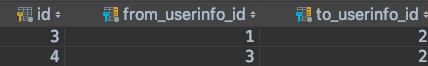

其中在程序或者说业务级别把 from_userinfo_id 当做男生(或女生), 把 to_userinfo_id 当女生(或男生)。下面的sql语句可以说明这个现象：

1. 查询第三张关系表前面那一列：obj.m:  select xx from xx where from_userinfo_id = 1/ SELECT "app01_girl"."id", "app01_girl"."nick" FROM "app01_girl" INNER JOIN "app01_love" ON ("app01_girl"."id" = "app01_love"."g_id") WHERE "app01_love"."b_id" = 1 
2. 查询第三张关系表后面那一列：obj.userinfo_set:  select xx from xx where to_userinfo_id = 1

按照之前在业务级别规定的from_userinfo_id存男生id, to_userinfo_id 存女生id, 查询方式如下: 
```
def index(request):
   # 多对多自关联 之通过男士查询女生
   boy_obj=models.Userinfo.objects.filter(id=4).first()
   res=boy_obj.m.all()
   for row in  res:
      print(row.nikename)
   return HttpResponse('OK')
   #多对多自关联 之通过女士查询男生
   girl_obj=models.Userinfo.objects.filter(id=5).first()
   res=girl_obj.userinfo_set.all()
   for obj in res:
      print(obj.nikename)
   return HttpResponse('OK')
   
```

## F查询与Q查询

### F查询

Django 提供 F() 来做这样的比较。F() 的实例可以在查询中引用字段，来比较同一个 model 实例中两个不同字段的值。

```
# 查询评论数大于收藏数的书籍
from django.db.models import F
# Book.objects.filter(commnetNum__lt='keepNum') 没有这样的方式，必须通过F来告诉django这是一个对Book字段的引用
Book.objects.filter(commnetNum__lt=F('keepNum'))
```
Django 支持 F() 对象之间以及 F() 对象和常数之间的加减乘除和取模的操作。
```
# 查询评论数大于收藏数2倍的书籍
Book.objects.filter(commnetNum__lt=F('keepNum')*2)
```
修改操作也可以使用F函数,比如将每一本书的价格提高30元：Book.objects.all().update(price=F("price")+30)　

### Q查询

对于Q查询的使用有2种方式：

#### 普通方式
filter() 等方法中的关键字参数查询都是一起进行AND的。如果你需要执行更复杂的查询（例如OR语句），你可以使用Q对象。

语法：

fifter（Q（查询条件1）| Q（查询条件2））

fifter（Q（查询条件2）& Q（查询条件3））

fifter（Q（查询条件4）& ~Q（查询条件5））

fifter（Q（查询条件6）| Q（Q（查询条件4）& ~ Q（Q（查询条件5）& Q（查询条件3）））包含

**注意：Q查询条件和非Q查询条件混合使用注意，不包Q（）的查询条件一点要放在Q（查询条件）后面**

#### Q对象构造搜索条件


传入普通条件进行查询:
```
q1 = Q()
# OR 是大写
q1.connector = 'OR'
q1.children.append(('id', 1))
q1.children.append(('id', 2))
q1.children.append(('id', 3))
    
models.Tb1.objects.filter(q1)
```
传入合并条件进行查询:
```
con = Q()

q1 = Q()
q1.connector = 'OR'
q1.children.append(('id', 1))
q1.children.append(('id', 2))
q1.children.append(('id', 3))

q2 = Q()
q2.connector = 'OR'
q2.children.append(('status', '在线'))
# 其实这里的第一句add使用AND还是OR都不影响结果，重要的是第二个，con.add(q2, 'AND') 其实封装的格式是 AND q2, AND 在 q2 之前
con.add(q1, 'AND')
con.add(q2, 'AND')

models.Tb1.objects.filter(con)
```

# ContentType

ContentType不是http协议中请求头里Content Type，而是Django程序启动后自带的一张表。在INSTALLED_APPS里可以看到有一个django.contrib.contenttypes。

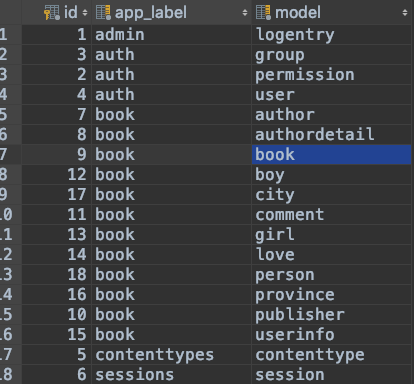
ContentType表记录了Django程序的所有app下model中的类名小写、和所在app的名称；

应用场景：
1. 通过ContentType中的app名称和表名，查找到Django model中所有表
2. 解决 1张表 同时 其他N张表建立外键，并且多个外键中只能选择1个，关系的复杂问题

## 通过ContentType中的app名称和表名，查找到Django model中所有表

```
from django.contrib.contenttypes.models import ContentType

c = ContentType.objects.get(app_label='book', model='city')
# book.models.City
c.model_class()
```

## 解决 1张表 同时 其他N张表建立外键，并且多个外键中只能选择1个，关系的复杂问题



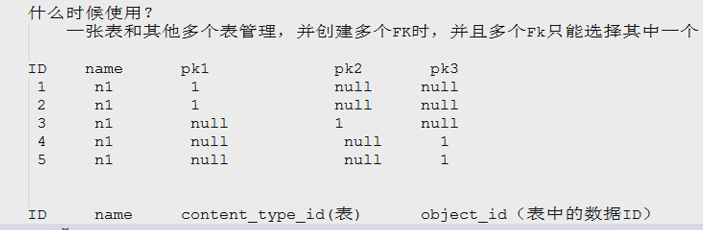

In [ ]:
# 假设你是一家在线教育的DBA，现有N种优惠券，每1种优惠券怎么分别对应 N门课程中的一1门课程
from django.db import models
from django.contrib.contenttypes.models import ContentType

class DegreeCourse(models.Model):
    """学位课程
     ID    名称
     1    学位课1
     2    学位课2

    """
    name = models.CharField(max_length=128, unique=True)
    coupon = GenericRelation('Coupon', content_type_field='content_types')


class Course(models.Model):
    """普通课程
     ID    名称
     1    普通课1
     2    普通课2
    """
    name = models.CharField(max_length=128, unique=True)

class Coupon(models.Model):
    """优惠券生成规则

    ID     优惠券名称         content_type_id(表)         object_id（表中数据ID）
     1       通用                 null                    null
     2       满100-10               8                      1
     3       满200-30               8                      2
     4       满200-30               9                      1
    总结：
    """
    name = models.CharField(max_length=32)
    content_types = models.ForeignKey(ContentType, on_delete=models.CASCADE, null=True)
    object_id = models.IntegerField(null=True)
    content_obj = GenericForeignKey('content_types', 'object_id')
    
"""
#给学位课1，创建优惠券100
#方式1
#1、在学位课表中 ，找到学位课1
d1=models.DegreeCourse.objects.get(id=1)
#2、在ContentType找到学位课表
c1= ContentType.objects.get(app_label='app01',model='degreecourse')
#3 给学位课1，创建优惠券100
# models.Coupon.objects.create(name='优惠券',brief='100',content_type=c1,object_id=d1.id)
# 方式2
# d1 = models.DegreeCourse.objects.get(id=1)
# models.Coupon.objects.create(name='优惠券',brief='100',content_object=d1)

#当前课程都有哪些优惠券？
d1 = models.DegreeCourse.objects.get(id=1)
# 查询关联的所有优惠券
print(d1.xx.all())
v=models.DegreeCourse.objects.values('name','xx__brief','xx__name')
print(v)
"""

# QuerySet查询优化

## select_related

对于一对一字段（OneToOneField）和外键字段（ForeignKey），可以使用select_related 来对QuerySet进行优化.
在对QuerySet使用select_related()函数后，Django会获取相应外键对应的对象，从而在之后需要的时候不必再查询数据库了。说到底，就是做了一个join查询，在一次sql查询中多拿了一些属性而已。

In [ ]:
class Province(models.Model):
    name = models.CharField(max_length=10)

    def __str__(self):
        return self.name

    class Meta:
        db_table = 'province'


class City(models.Model):
    name = models.CharField(max_length=5)
    models.CharField
    province = models.ForeignKey(Province, on_delete=models.CASCADE)

    def __str__(self):
        return self.name

    class Meta:
        db_table = "city"


class Person(models.Model):
    firstname = models.CharField(max_length=10)
    lastname = models.CharField(max_length=10)
    visitation = models.ManyToManyField(City, related_name="visitor")
    hometown = models.ForeignKey(City, related_name="birth", on_delete=models.CASCADE)
    living = models.ForeignKey(City, related_name="citizen", on_delete=models.CASCADE)

    def __str__(self):
        return self.firstname + self.lastname

    class Meta:
        db_table = "person"

In [ ]:
citys = City.objects.all()
for c in citys:
    print c.province

这样会导致线性的SQL查询，因为有3个city对象就导致了4次SQL查询

In [ ]:
# 一次inner join 
citys = City.objects.select_related("province").all()
for c in citys:
    print c.province

### select_related用法

select_related() 接受可变长参数(意味着可以不传参数)，每个参数是需要获取的外键（父表的内容）的字段名，以及外键的外键的字段名、外键的外键的外键…。若要选择外键的外键需要使用两个下划线“__”来连接。

In [ ]:
# Django使用了2次 INNER JOIN 来完成请求，获得了city表和province表的内容并添加到结果表的相应列，这样在调用 jack.living的时候也不必再次进行SQL查询。
# 然而，未指定的外键则不会被添加到结果中。这时候如果需要获取jack的故乡就会进行SQL查询了 jack.hometown.province
# 1.7版本以下：Person.objects.select_related('hometown__province').select_related('living__province')
# 1.7版本以上：Person.objects.select_related('hometown__province','living__province')
p1 = Person.objects.select_related('living__province').get(firstname='jack')
p1.living.province

无参数：select_related() 也可以不加参数，这样表示要求Django尽可能深的select_related。例如：

jack = Person.objects.select_related().get(firstname='jack')
但要注意两点：
1. Django本身内置一个上限，对于特别复杂的表关系，Django可能在你不知道的某处跳出递归，从而与你想的做法不一样。具体限制是怎么工作的我表示不清楚。
2. Django并不知道你实际要用的字段有哪些，所以会把所有的字段都抓进来，从而会造成不必要的浪费而影响性能。

**总结：**
1. select_related主要针一对一和多对一关系进行优化。
2. select_related使用SQL的JOIN语句进行优化，通过减少SQL查询的次数来进行优化、提高性能。
可以通过可变长参数指定需要select_related的字段名。也可以通过使用双下划线“__”连接字段名来实现指定的递归查询。没有指定的字段不会缓存，没有指定的深度不会缓存，如果要访问的话Django会再次进行SQL查询。也接受无参数的调用，Django会尽可能深的递归查询所有的字段。但注意有Django递归的限制和性能的浪费。
3. Django >= 1.7，链式调用的select_related相当于使用可变长参数。Django < 1.7，链式调用会导致前边的select_related失效，只保留最后一个。

## prefetch_related

对于多对多字段（ManyToManyField）和一对多字段，可以使用prefetch_related()来进行优化。

prefetch_related()和select_related()的设计目的很相似，都是为了减少SQL查询的数量，但是实现的方式不一样。后者是通过JOIN语句，在SQL查询内解决问题。但是对于多对多关系，使用SQL语句解决就显得有些不太明智，因为JOIN得到的表将会很长，会导致SQL语句运行时间的增加和内存占用的增加。若有n个对象，每个对象的多对多字段对应Mi条，就会生成Σ(n)Mi行的结果表。

prefetch_related()的解决方法是，分别查询每个表，然后用Python处理他们之间的关系(其实就是用in)。继续以上边的例子进行说明，如果我们要获得张三所有去过的城市，使用prefetch_related()应该是这么做：
p1 = Person.objects.prefetch_related('visitation').get(firstname='jack')
对应的sql语句:
```
SELECT `person`.`id`, `person`.`firstname`, `person`.`lastname`, `person`.`hometown_id`, `person`.`living_id` FROM `person` WHERE `person`.`firstname` = 'jack'; args=('jack',)
SELECT (`person_visitation`.`person_id`) AS `_prefetch_related_val_person_id`, `city`.`id`, `city`.`name`, `city`.`province_id` FROM `city` INNER JOIN `person_visitation` ON (`city`.`id` = `person_visitation`.`city_id`) WHERE `person_visitation`.`person_id` IN (1); args=(1,)

```
第一条SQL查询仅仅是获取jack的Person对象，第二条比较关键，它选取关系表person_visitation中person_id为jack的行，然后和city表内联（INNER JOIN 也叫等值连接）得到结果表。


In [5]:
Province.objects.prefetch_related('city_set')
"""
SELECT `province`.`id`, `province`.`name` FROM `province`  LIMIT 21; args=()
SELECT `city`.`id`, `city`.`name`, `city`.`province_id` FROM `city` WHERE `city`.`province_id` IN (1, 2); args=(1, 2)
"""

### 使用方法

和select_related()一样，prefetch_related()也支持深度查询，例如要获得所有姓张的人去过的省

In [ ]:
zhangs = Person.objects.prefetch_related('visitation__province').filter(firstname__startswith='张')
for i in zhangs:
    for city in i.visitation.all():
        print(city.province)

要注意的是，在使用QuerySet的时候，一旦在链式操作中改变了数据库请求，之前用prefetch_related缓存的数据将会被忽略掉。这会导致Django重新请求数据库来获得相应的数据，从而造成性能问题。这里提到的改变数据库请求指各种filter()、exclude()等等最终会改变SQL代码的操作。而all()并不会改变最终的数据库请求，因此是不会导致重新请求数据库的。

举个例子，要获取所有人访问过的城市中带有"市"字的城市，这样做会导致大量的SQL查询：



In [ ]:
# 因为数据库中有4人，导致了2+4次SQL查询
plist = Person.objects.prefetch_related('visitation')
lis = [p.visitation.filter(name__contains="市") for p in plist]

QuerySet是lazy的，要用的时候才会去访问数据库。运行到第二行Python代码时，for循环将plist看做iterator，这会触发数据库查询。最初的两次SQL查询就是prefetch_related导致的。

虽然已经查询结果中包含所有所需的city的信息，但因为在循环体中对Person.visitation进行了filter操作，这显然改变了数据库请求。因此这些操作会忽略掉之前缓存到的数据，重新进行SQL查询。

但是如果有这样的需求了应该怎么办呢？在Django >= 1.7，可以通过Prefetch对象来实现，如果环境是Django < 1.7，可以在Python中完成这部分操作。

In [ ]:
plist = Person.objects.prefetch_related('visitation')
lis = [[city for city in p.visitation.all() if "市" in city.name] for p in plist]

### Prefetch 对象

在Django >= 1.7，可以用Prefetch对象来控制prefetch_related函数的行为。


Prefetch对象的特征：
1. 一个Prefetch对象只能指定一项prefetch操作。
2. Prefetch对象对字段指定的方式和prefetch_related中的参数相同，都是通过双下划线连接的字段名完成的。
3. 可以通过 queryset 参数手动指定prefetch使用的QuerySet。
4. 可以通过 to_attr 参数指定prefetch到的属性名。
5. Prefetch对象和字符串形式指定的lookups参数可以混用。
继续上面的例子，获取所有人访问过的城市中带有"武"字和"州"的城市：



In [ ]:
wus = City.objects.filter(name__contains = "武")
zhous = City.objects.filter(name__contains = "州")
plist = Person.objects.prefetch_related(
    Prefetch('visitation', queryset = wus, to_attr = "wu_city"),
    Prefetch('visitation', queryset = zhous, to_attr = "zhou_city"),)
lis1 = [p.wu_city for p in plist]
lis2 = [p.zhou_city for p in plist]

### None
可以通过传入一个None来清空之前的prefetch_related。就像这样：prefetch_cleared_qset = qset.prefetch_related(None)

**总结：**
1. prefetch_related主要针一对多和多对多关系进行优化。
2. prefetch_related通过分别获取各个表的内容，然后用Python处理他们之间的关系来进行优化。
3. 可以通过可变长参数指定需要select_related的字段名。指定方式和特征与select_related是相同的。
4. 在Django >= 1.7可以通过Prefetch对象来实现复杂查询，但低版本的Django好像只能自己实现。作为prefetch_related的参数，Prefetch对象和字符串可以混用。prefetch_related的链式调用会将对应的prefetch添加进去，而非替换，似乎没有基于不同版本上区别。
5. 可以通过传入None来清空之前的prefetch_related。